<a href="https://colab.research.google.com/github/LavanyaPobbathi/Text-Summarization-Research-Project/blob/main/FlowchartImage_ExtractionPatent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opencv-python

In [ ]:
pip install opencv-python pytesseract

In [ ]:
!pip install tesseract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tesseract: filename=tesseract-0.1.3-py3-none-any.whl size=45562550 sha256=896e521bb0418838e769bf61c60746ae03114cb1fe2ab56a7a31c6df252fcf42
  Stored in directory: /root/.cache/pip/wheels/71/c9/aa/698c579693e83fdda9ad6d6f0d8f61ed986e27925ef576f109
Successfully built tesseract


In [ ]:
!apt-get install -y tesseract-ocr
!pip install pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (1,997 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

Saving image7.jpg to image7.jpg
  Id  Bounding_Box          Center      Shape      Text                                                                                                                                          Scientific_Notation
----  --------------------  ----------  ---------  --------------------------------------------------------------------------------------------------------------------------------------------  ---------------------
 195  (267, 423, 278, 221)  (406, 533)  diamond    Does 1 e user decreas® the volume when the S audio file is output quietly and increase the volume when the audio file is output loudly?       ['1']
 538  (268, 141, 276, 222)  (406, 252)  diamond    Does 10 he user increasé ‘the volume when the’ audio file is output quietly ) and decrease the volume when the audio file is output loudly?,  ['10']
  43  (97, 580, 167, 62)    (180, 611)  rectangle  Reduce compression of the audio file                                                      

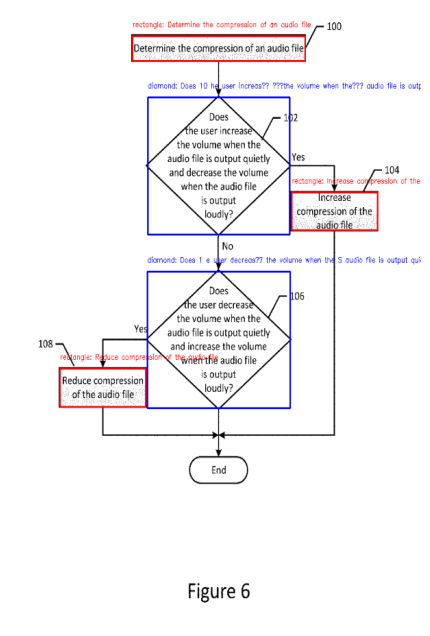

In [ ]:
import cv2
import numpy as np
from pytesseract import pytesseract
from tabulate import tabulate
import math
import re
from PIL import Image
import io
import matplotlib.pyplot as plt
from google.colab import files

def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def classify_flowchart_symbol(contour):
    bounding_box = cv2.boundingRect(contour)
    x, y, w, h = bounding_box
    aspect_ratio = float(w) / h
    contour_area = cv2.contourArea(contour)
    bounding_box_area = w * h
    extent = float(contour_area) / bounding_box_area
    shape = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)

    if len(shape) == 4 and 0.9 < aspect_ratio < 1.1:
        return "square"
    elif len(shape) == 4 and extent < 0.8:
        return "diamond"
    elif len(shape) == 4:
        return "rectangle"
    elif len(shape) == 3:
        return "triangle"
    else:
        return "unknown"

def clean_extracted_text(text):
    text = text.replace('|', '').replace('/', '').replace('_', '').replace('-', '')
    text = ' '.join(text.split())
    return text

def improved_text_extraction(roi):
    roi = cv2.GaussianBlur(roi, (3, 3), 0)
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(roi, config=custom_config).strip()
    text = clean_extracted_text(text)
    return text

def extract_scientific_notations(text):
    scientific_notations = re.findall(r'[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?', text)
    return scientific_notations

def main():
    uploaded = files.upload()
    uploaded_image = uploaded[list(uploaded.keys())[0]]  # Assuming you've uploaded a single image

    image = cv2.imdecode(np.frombuffer(uploaded_image, np.uint8), cv2.IMREAD_COLOR)

    height, width = image.shape[:2]
    new_width = 800
    new_height = int((new_width / width) * height)
    resized_image = cv2.resize(image, (new_width, new_height))
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    _, thresholded_image = cv2.threshold(grayscale_image, 127, 255, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    nodes = {}
    max_area = 0
    max_idx = -1
    output_image = resized_image.copy()

    for idx, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_idx = idx

    center = (new_width // 2, new_height // 2)

    for idx, contour in enumerate(contours):
        if idx == max_idx:
            continue

        area = cv2.contourArea(contour)

        if area > 100:
            x, y, w, h = cv2.boundingRect(contour)
            symbol = classify_flowchart_symbol(contour)

            if symbol != "unknown":
                shape_center = (x + w // 2, y + h // 2)
                distance_to_center = euclidean_distance(shape_center, center)

                roi = grayscale_image[max(0, y-10):min(y+h+10, resized_image.shape[0]), max(0, x-10):min(x+w+10, resized_image.shape[1])]
                text = improved_text_extraction(roi)
                scientific_notations = extract_scientific_notations(text)

                nodes[distance_to_center] = {
                    'Id': idx,
                    'Bounding_Box': (x, y, w, h),
                    'Center': shape_center,
                    'Shape': symbol,
                    'Text': text,
                    'Scientific_Notation': scientific_notations
                }

                color = (0, 255, 0)
                if symbol == "rectangle":
                    color = (0, 0, 255)
                elif symbol == "diamond":
                    color = (255, 0, 0)

                cv2.rectangle(output_image, (x, y), (x + w, y + h), color, 2)
                cv2.putText(output_image, f'{symbol}: {text}', (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

    sorted_nodes = dict(sorted(nodes.items()))

    print(tabulate(list(sorted_nodes.values()), headers='keys'))

    output_width = 600
    output_height = 900

    resized_output_image = cv2.resize(output_image, (output_width, output_height))

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(resized_output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()